In [5]:
import sys
sys.path.append("../../../../src")
sys.path.append("../../")
import os
import numpy as np
import pickle
import scipy.io as sio
from example_reactiondiffusion import get_rd_data
from autoencoder import full_network
from training import create_feed_dictionary
from sindy_utils import sindy_simulate
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [8]:
data_path = '../../sindy_models/original/'
save_name = 'model1'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.compat.v1.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

In [9]:
_,_,test_data = get_rd_data()

## Single trajectory plots

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from ../../sindy_models/original/model1


In [11]:
z_sim = sindy_simulate(test_set_results['z'][0], test_data['t'][:,0],
                       params['coefficient_mask']*test_set_results['sindy_coefficients'],
                       params['poly_order'], params['include_sine'])

<ipython-input-12-a5d61e7e4c3a>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(test_set_results['z'][:,0], 'k', color='#888888', linewidth=2)


(-49.95, 1048.95, -1.0724501819756191, 1.071899139710049)

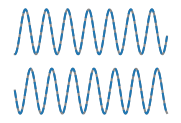

In [12]:
plt.figure(figsize=(3,2))
plt.subplot(2,1,1)
plt.plot(test_set_results['z'][:,0], 'k', color='#888888', linewidth=2)
plt.plot(z_sim[:,0], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

plt.subplot(2,1,2)
plt.plot(test_set_results['z'][:,1], color='#888888', linewidth=2)
plt.plot(z_sim[:,1], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

([], [])

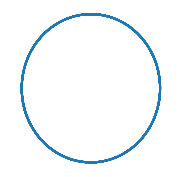

In [13]:
plt.figure(figsize=(3,3))
plt.plot(z_sim[:,0], z_sim[:,1], linewidth=2)
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

In [14]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.var(test_data['x'])
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.var(test_data['dx'])
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.var(test_set_results['dz'])

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.015898
Decoder relative SINDy error: 0.015780
SINDy reltive error, z: 0.002132


In [15]:
# Original Notebook
# Decoder relative error: 0.015898
# Decoder relative SINDy error: 0.015780
# SINDy reltive error, z: 0.002132


# Replicated
# Decoder relative error: 0.015898
# Decoder relative SINDy error: 0.015780
# SINDy reltive error, z: 0.002132

# Decoder relative error: 0.015898
# Decoder relative SINDy error: 0.015780
# SINDy reltive error, z: 0.002132

# Deterministic dataset

In [9]:
import pandas as pd

In [10]:
def sindy_library_tf_order2(z, dz, latent_dim, poly_order, include_sine=False):
    """
    Build the SINDy library for a second order system. This is essentially the same as for a first
    order system, but library terms are also built for the derivatives.
    """
    library = ['1']

    z_combined = z + dz

    for i in range(2*latent_dim):
        library.append(z_combined[i])

    if poly_order > 1:
        for i in range(2*latent_dim):
            for j in range(i,2*latent_dim):
                library.append(f'{z_combined[i]}*{z_combined[j]}')

    if poly_order > 2:
        for i in range(2*latent_dim):
            for j in range(i,2*latent_dim):
                for k in range(j,2*latent_dim):
                    library.append(f'{z_combined[i]}*{z_combined[j]}*{z_combined[k]}')

    if poly_order > 3:
        for i in range(2*latent_dim):
            for j in range(i,2*latent_dim):
                for k in range(j,2*latent_dim):
                    for p in range(k,2*latent_dim):
                        library.append(f'{z_combined[i]}*{z_combined[j]}*{z_combined[k]}*{z_combined[p]}')

    if poly_order > 4:
        for i in range(2*latent_dim):
            for j in range(i,2*latent_dim):
                for k in range(j,2*latent_dim):
                    for p in range(k,2*latent_dim):
                        for q in range(p,2*latent_dim):
                            library.append(f'{z_combined[i]}*{z_combined[j]}*{z_combined[k]}*{z_combined[p]}*{z_combined[q]}')

    if include_sine:
        for i in range(2*latent_dim):
            library.append(f'sin({z_combined[i]})')

    return library

In [11]:
coefficient_names = sindy_library_tf_order2(['z1', 'z2'], ['dz1', 'dz2'], 1, 3, include_sine=True)
coefficient_names

['1',
 'z1',
 'z2',
 'z1*z1',
 'z1*z2',
 'z2*z2',
 'z1*z1*z1',
 'z1*z1*z2',
 'z1*z2*z2',
 'z2*z2*z2',
 'sin(z1)',
 'sin(z2)']

In [12]:
coefficient_masks = []

In [13]:
tf.reset_default_graph()
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
coefficient_masks.append(params['coefficient_mask'])

In [14]:
len(coefficient_masks), coefficient_masks[0].shape

(1, (12, 2))

In [15]:
masked_coefficients_per_dim = [np.array([[(c[i].round(2) if m else '-') for c, m in zip(coefficients, mask[:, i])] for coefficients, mask in zip([test_set_results['sindy_coefficients']], coefficient_masks)]).reshape(1, 12) for i in range(2)]

In [16]:
pd.DataFrame(masked_coefficients_per_dim[0], columns=coefficient_names)

1 z1     z2 z1*z1 z1*z2 z2*z2 z1*z1*z1 z1*z1*z2 z1*z2*z2 z2*z2*z2 sin(z1)  \
0  -  -  -0.85     -     -     -        -        -        -        -       -   

  sin(z2)  
0       -

In [17]:
pd.DataFrame(masked_coefficients_per_dim[1], columns=coefficient_names)

1    z1 z2 z1*z1 z1*z2 z2*z2 z1*z1*z1 z1*z1*z2 z1*z2*z2 z2*z2*z2 sin(z1)  \
0  -  0.97  -     -     -     -        -        -        -        -       -   

  sin(z2)  
0       -